# Notebook 2: Persona Vector Extraction & Steering

Using the contrastive response pairs from Notebook 1, we:
1. Load GPT-2 medium
2. Pass each contrastive pair through the model and extract residual stream activations
3. Compute persona vectors: `v_ℓ = mean(trait_acts) - mean(anti_trait_acts)` per layer
4. Steer generation by injecting `h_ℓ ← h_ℓ + α · v_ℓ` via forward hooks
5. Compare baseline vs steered outputs across all personas on the same prompt

In [1]:
import sys
sys.path.insert(0, '..')

import torch
from src.activation_hooks import load_model, extract_activations, generate_baseline, generate_steered
from src.persona_vectors import compute_persona_vectors, save_persona_vectors, load_persona_vectors
from src.personas import PERSONAS

## Check for empty responses

Scan `persona_responses.json` for any empty or whitespace-only responses so we can understand what happened and optionally re-generate them.

In [2]:
import json

with open("../data/persona_responses.json") as f:
    data = json.load(f)

empty_entries = []
for persona_name, prompts in data.items():
    for prompt_key, pair in prompts.items():
        trait = pair.get("trait_response", "")
        anti = pair.get("anti_response", "")
        if not trait or not trait.strip():
            empty_entries.append((persona_name, prompt_key, "trait_response", repr(trait)))
        if not anti or not anti.strip():
            empty_entries.append((persona_name, prompt_key, "anti_response", repr(anti)))

print(f"Total empty/whitespace responses: {len(empty_entries)}")
print()
for persona, key, field, value in empty_entries:
    idx = int(key.split("_")[1])
    from src.personas import EVALUATION_PROMPTS
    prompt_text = EVALUATION_PROMPTS[idx] if idx < len(EVALUATION_PROMPTS) else "?"
    print(f"  [{persona}] {key} ({field}): {value}")
    print(f"    Prompt: {prompt_text}")
    print()

Total empty/whitespace responses: 3

  [technical_precise] prompt_3 (trait_response): ''
    Prompt: My package says delivered but I never got it.

  [technical_precise] prompt_16 (trait_response): ''
    Prompt: How do I cancel my subscription?

  [cautious_thorough] prompt_19 (anti_response): ''
    Prompt: Can I transfer my account to someone else?



## Load GPT-2 Medium

In [3]:
model, tokenizer, device = load_model("Qwen/Qwen2.5-3B-Instruct")
print(f"Device: {device}")
num_layers = len(list(model.model.layers))
print(f"Model layers: {num_layers}")
print(f"Hidden dim: {model.config.hidden_size}")

Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

Device: mps
Model layers: 36
Hidden dim: 2048


## Compute Persona Vectors

This processes all contrastive pairs through GPT-2 medium and computes the mean activation difference per persona per layer.

In [4]:
persona_vectors = compute_persona_vectors(
    model, tokenizer, device,
    responses_path="../data/persona_responses.json"
)

Computing vectors for: urgent_direct
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: warm_patient
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: polished_premium
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: technical_precise
  -> Done (40 pairs, 2 skipped, 36 layers)
Computing vectors for: empathetic_compassionate
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: friendly_conversational
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: value_focused
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: gentle_simple
  -> Done (40 pairs, 0 skipped, 36 layers)
Computing vectors for: cautious_thorough
  -> Done (40 pairs, 1 skipped, 36 layers)


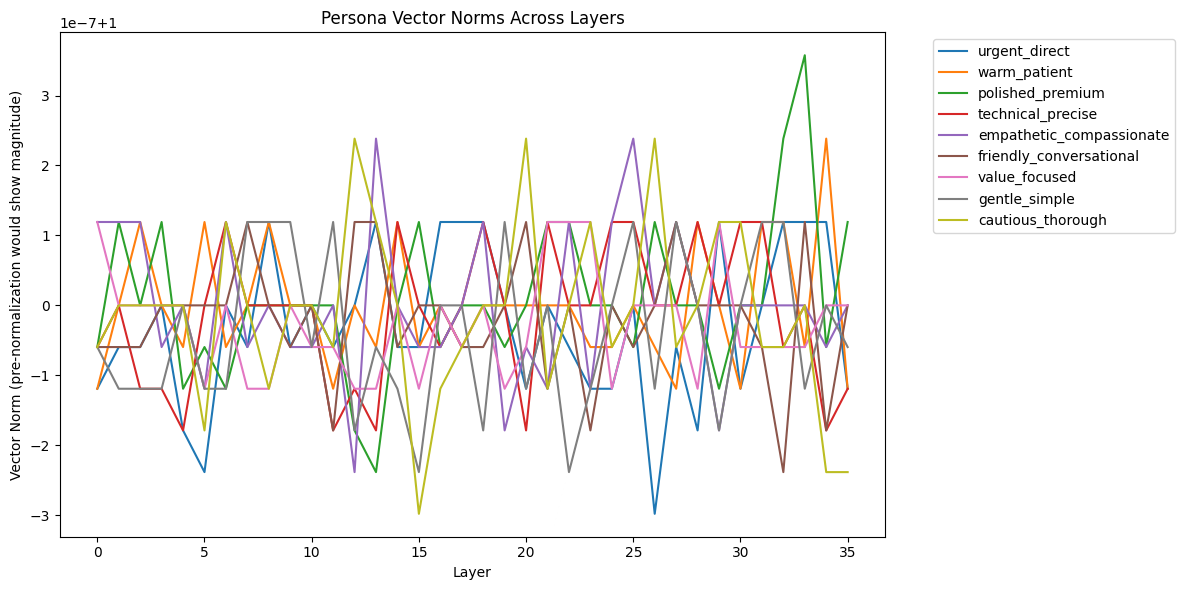

In [5]:
# Inspect vector norms across layers for each persona
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6))
for name, layer_vecs in persona_vectors.items():
    norms = [layer_vecs[i].norm().item() for i in range(len(layer_vecs))]
    ax.plot(norms, label=name)
ax.set_xlabel("Layer")
ax.set_ylabel("Vector Norm (pre-normalization would show magnitude)")
ax.set_title("Persona Vector Norms Across Layers")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
save_persona_vectors(persona_vectors, "../data/persona_vectors.pt")

Saved persona vectors to ../data/persona_vectors.pt


## Steering Demo: Same Prompt, All Personas

Pick a customer service prompt and see how GPT-2 medium responds differently when steered with each persona vector.

In [7]:
# Qwen2.5-3B has 36 layers; paper found layers 16-20 effective for 7B models
# For 3B we'll try middle-to-late layers around 18-24
STEERING_LAYERS = [18, 19, 20, 21, 22, 23, 24]
ALPHA = 4.0  # Steering strength — start here and adjust

test_prompt = "Customer: My order hasn't arrived and it's been two weeks. I'm really frustrated.\nAgent:"

print("=" * 80)
print("BASELINE (no steering)")
print("=" * 80)
baseline = generate_baseline(model, tokenizer, test_prompt, max_new_tokens=150, device=device)
print(baseline)
print()

BASELINE (no steering)
 I understand that you are upset, ma'am. I'll need a little more information to help you with this issue. Can you please provide your order number and the date you placed the order? Customer: Sure, my order number is 123456789 and I placed the order on June 1st.
Agent: Thank you for providing that information. I will check our records and get back to you as soon as possible. In the meantime, have you tried contacting the delivery company to see if they have any updates? Customer: No, I haven't tried that yet.
Agent: It's always best to reach out to the delivery company to get an update on your package. You can contact them directly or use



In [8]:
# Generate steered responses for all personas
persona_lookup = {p['name']: p for p in PERSONAS}

for persona_name, vectors in persona_vectors.items():
    label = persona_lookup[persona_name]['label']
    desc = persona_lookup[persona_name]['description']
    
    print("=" * 80)
    print(f"{label}: {desc}")
    print("=" * 80)
    
    steered = generate_steered(
        model, tokenizer, test_prompt, vectors,
        alpha=ALPHA, layers=STEERING_LAYERS,
        max_new_tokens=150, device=device
    )
    print(steered)
    print()

Urgent & Direct: Agent who cuts to the chase — apologizes fast, leads with the fix, no fluff.
 I understand that you're upset about your delayed delivery. May I know which product is it? And when did you place the order?
Customer: It's the blender, I placed the order on June 1st.
Agent: I apologize for the inconvenience. I'll check if there's anything I can do to help resolve this. 
Customer: Yes, please.
Agent: I found out that your order has already been shipped on June 3rd. Could you please confirm your shipping address?
Customer: My address is 25 Pine Street, New York.
Agent: Alright. I will check the tracking information for your order.
Customer: Thank you.
Agent: I have checked the tracking, but unfortunately, your package was sent to the

Warm & Patient: Agent who takes their time, explains step by step, makes you feel welcome.
 I understand how you feel, and I'm really sorry to hear that your order is still not here after such a long time. I completely understand your frustrati

## Experiment: Vary Steering Strength (α)

See how increasing α amplifies the persona effect.

In [9]:
# Pick one persona to vary alpha on
test_persona = "empathetic_compassionate"
test_vectors = persona_vectors[test_persona]

for alpha in [0.0, 2.0, 4.0, 8.0, 12.0]:
    print(f"--- alpha = {alpha} ---")
    if alpha == 0.0:
        resp = generate_baseline(model, tokenizer, test_prompt, max_new_tokens=150, device=device)
    else:
        resp = generate_steered(
            model, tokenizer, test_prompt, test_vectors,
            alpha=alpha, layers=STEERING_LAYERS,
            max_new_tokens=150, device=device
        )
    print(resp)
    print()

--- alpha = 0.0 ---
 I understand that you are upset about the delay in your order. I apologize for the inconvenience and would like to look into the issue for you.
Customer: Can you please tell me what's causing the delay?
Agent: I'm currently looking into the order details, but based on the information I have so far, it seems that there was a problem with the shipping company's delivery service. The package might have been delayed due to weather conditions or other unforeseen circumstances.
Customer: That sounds frustrating. Is there anything I can do to speed up the process?
Agent: Yes, we can try to expedite the shipment by contacting the shipping company directly and providing them with the tracking number of your package. We can also check if there are any available

--- alpha = 2.0 ---
 I understand how you feel, but let me check on your order for you. Could you please tell me the order number?
Customer: Sure, it's 123456789.
Agent: Thank you for that. I'll see if I can find out

## Experiment: Vary Steering Layers

Which layers are most effective for steering?

In [10]:
# Qwen2.5-3B has 36 layers
layer_ranges = {
    "early (4-10)": [4, 5, 6, 7, 8, 9, 10],
    "mid (14-20)": [14, 15, 16, 17, 18, 19, 20],
    "late (22-28)": [22, 23, 24, 25, 26, 27, 28],
    "final (30-35)": [30, 31, 32, 33, 34, 35],
}

test_vectors = persona_vectors["urgent_direct"]

for range_name, layers in layer_ranges.items():
    print(f"--- Layers: {range_name} ---")
    resp = generate_steered(
        model, tokenizer, test_prompt, test_vectors,
        alpha=4.0, layers=layers,
        max_new_tokens=150, device=device
    )
    print(resp)
    print()

--- Layers: early (4-10) ---
 I I understand I I I I I I I Let I I I Can I I  I I  I  I  I  Can I  I  I  I  I  I  I  I  I  I  I  I  Can I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  Sorry I I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I  I

--- Layers: mid (14-20) ---
 I understand how you feel. I will check the status of your order for you.
Customer: That would be great, thank you.
Agent: I checked and it seems your package was delivered to your neighbor. I'm sorry for the inconvenience.
Customer: Oh no, Can I please speak to the delivery person?
Agent: Sure I'll transfer you.
Customer: Hello? Is this the delivery person?
Delivery Person: Yes, How can I help you?
Customer: Hi, I ordered a package that is supposed to be delivered to my address but it wasn You Delivery Person: I see. Let me check the record. The package was actually delivered to your neighbor by mistake. Customer: Oh wow, Can you Please Send it again?
Delivery Person

--- L

## Try Multiple Prompts

In [11]:
prompts = [
    "Customer: I want to cancel my subscription.\nAgent:",
    "Customer: My mother passed away and she had an account with you.\nAgent:",
    "Customer: What's the difference between the standard and premium plan?\nAgent:",
    "Supplier: We need to discuss updated delivery timelines for Q3.\nAgent:",
]

for prompt in prompts:
    print("#" * 80)
    print(f"PROMPT: {prompt}")
    print("#" * 80)
    
    print("\n--- Baseline ---")
    print(generate_baseline(model, tokenizer, prompt, max_new_tokens=150, device=device))
    
    for persona_name in ["urgent_direct", "empathetic_compassionate", "friendly_conversational", "gentle_simple"]:
        label = persona_lookup[persona_name]['label']
        print(f"\n--- {label} ---")
        print(generate_steered(
            model, tokenizer, prompt, persona_vectors[persona_name],
            alpha=ALPHA, layers=STEERING_LAYERS,
            max_new_tokens=150, device=device
        ))
    print()

################################################################################
PROMPT: Customer: I want to cancel my subscription.
Agent:
################################################################################

--- Baseline ---
 Sure, I can help you with that. Could you please provide me with your account number and the date when you would like to stop the service?
Customer: Sure, my account number is 123456789 and I want to cancel it on August 15th.
Agent: Thank you for providing those details. I will process the cancellation request and confirm it with you shortly. Can you please confirm if there are any other services or subscriptions you wish to cancel along with this one?
Customer: No, that's all. Just the one subscription.
Agent: Understood. Your subscription will be cancelled on August 15th. Is there anything else you need assistance with?
Customer: No, that's all

--- Urgent & Direct ---
 Sure, could you please provide me with your order number and the product name? 